# ***화승***

## ***IMPORT LIBRARY***
---

In [1]:
### Library Import 
import os
import re
import sys
import glob
import shap
import optuna
import pickle
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns
import xgboost as xgb
from math import ceil
from tqdm import tqdm
from scipy import stats
import statsmodels.api as sm
from functools import partial
from collections import Counter
from pandarallel import pandarallel
from xgboost import XGBRegressor, callback as xgb_callback
from datetime import timedelta, time, datetime
from scipy.stats import truncnorm
from IPython.display import Image
from optbinning import OptimalBinning
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.patches as patches
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
warnings.filterwarnings('ignore')
plt.rc('font', family='Apple SD Gothic Neo')

# Pandas 옵션 설정 
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

# Scikit-Learn 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence 

# Import fns 
from utils import * 
from hwaseung_fn import * 

In [2]:
### Parameters 
path = '/Users/hwijongim/Library/CloudStorage/OneDrive-앰버로드/문서 - Solution/2502_화승/20.수행/22.분석과제/250408_분석_sm'
p_type = 'FMB'
cluster = 2

## ***Load Dataset***
---

In [3]:
### Load Raw Data 
# Data Import 
log_df, qa_df, recipe_df, info, weather_df = import_raw_data(path) 
recipe_origin_df = recipe_df.copy() 

# Print 
print('='*100)
print(f'Log Dataset: {log_df.shape}')
print(f'QA Dataset: {qa_df.shape}')
print(f'Recipe Dataset: {recipe_df.shape}')
print(f'INFO Dataset: {info.shape}')
print(f'Weather Dataset: {weather_df.shape}')
print('='*100)

Log Dataset: (9478081, 37)
QA Dataset: (334291, 16)
Recipe Dataset: (1813072, 13)
INFO Dataset: (80, 2)
Weather Dataset: (1268, 5)


## ***Data Preprocessing***
---

In [4]:
### Log Dataset 정제 
log_df4, log_df5 = prep_log(log_df)

# Print 
print('='*100)
print(f'Log Dataset: {log_df4.shape}')
print(f'Log Train Dataset: {log_df5.shape}')
print('='*100)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Log Dataset: (8566802, 39)
Log Train Dataset: (128985, 18)


In [5]:
### QA Dataset 정제 
qa_df4, qa_df5 = prep_qa(qa_df)

# Print 
print('='*100)
print(f'Qa Dataset: {qa_df4.shape}')
print(f'Qa Train Dataset: {qa_df5.shape}')
print('='*100)

Qa Dataset: (242922, 4)
Qa Train Dataset: (137180, 14)


In [6]:
### Recipe Dataset 정제 
recipe_df = prep_recipe(recipe_origin_df, info) 

# Print 
print('='*100)
print(f'Recipe Dataset: {recipe_df.shape}')
print('='*100)

Recipe Dataset: (123200, 2)


In [7]:
### Concat Dataset 
df1 = pd.merge(left=log_df5, right=qa_df5, on="작업지시번호-배치", how="left")
df2 = pd.merge(left=df1, right=recipe_df, on="작업지시번호-배치", how="left")
df3 = pd.merge(left=df2, right=weather_df, on="연월일", how="left").drop(["연월일"], axis=1)    

# Print 
print('='*100)
print(f'Daset Shape: {df3.shape}')
print('='*100)


Daset Shape: (128985, 35)


In [8]:
### Get Cluster Column 
dataset = create_cluster_col(df3, p_type)  
dataset = dataset[dataset['Cluster']==cluster].reset_index(drop=True).copy()

# Print 
print('='*100)
print(f'Train Dataset Shape: {dataset.shape}')
print('='*100)

Train Dataset Shape: (21888, 36)


In [9]:
### Target Value 확인 
# 확인할 컬럼 리스트
target_lst = [
    "cycle time", "Ct 90_결과", "M/B_결과", "M/B_기준",
    "Scorch_결과", "Vm_결과", "경도_결과"
]

# Print 
print('='*100)
print(dataset[target_lst].count())
print('='*100)

cycle time    21830
Ct 90_결과      15168
M/B_결과            0
M/B_기준            0
Scorch_결과      1983
Vm_결과          8436
경도_결과         12738
dtype: int64


## ***MODELLING***
---

In [10]:
### Train Test Split 
# Targets 
targets = ['Ct 90_결과','Scorch_결과','Vm_결과','경도_결과']

# CT90 
ct_train_dataset, ct_test_dataset, ct_scaler, ct_scaler_cols = create_train_test_dataset(dataset, targets[0], p_type)

# Scorch
sc_train_dataset, sc_test_dataset, sc_scaler, sc_scaler_cols = create_train_test_dataset(dataset, targets[1], p_type)

# Vm 
vm_train_dataset, vm_test_dataset, vm_scaler, vm_scaler_cols = create_train_test_dataset(dataset, targets[2], p_type)

# Hard 
hard_train_dataset, hard_test_dataset, hard_scaler, hard_scaler_cols = create_train_test_dataset(dataset, targets[3], p_type)

# Print 
print('='*100)
print(f"{'Ct 90_결과':<20} | {len(ct_train_dataset):>14,} | {len(ct_test_dataset):>13,}")
print(f"{'Scorch_결과':<20} | {len(sc_train_dataset):>14,} | {len(sc_test_dataset):>13,}")
print(f"{'Vm_결과':<20} | {len(vm_train_dataset):>14,} | {len(vm_test_dataset):>13,}")
print(f"{'경도_결과':<19} | {len(hard_train_dataset):>14,} | {len(hard_test_dataset):>13,}") 
print("="*100) 

Ct 90_결과             |          2,241 |           526
Scorch_결과            |          1,313 |           309
Vm_결과                |          5,907 |         1,386
경도_결과               |          4,091 |           960


[I 2025-10-31 10:07:36,784] A new study created in memory with name: no-name-7f2160b6-d9cb-4438-8d22-3579b193fe20


학습할 Tree Features: 17 | ['step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'Vm_feature']
학습 Tree 데이터 수: 2241


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-31 10:07:37,776] Trial 0 finished with value: 11.184303841333202 and parameters: {'n_estimators': 2984, 'max_depth': 11, 'learning_rate': 0.2756929683334096, 'subsample': 0.7621059348164069, 'gamma': 0.017685530400130267, 'reg_lambda': 0.03513491009599395}. Best is trial 0 with value: 11.184303841333202.
[I 2025-10-31 10:07:38,707] Trial 1 finished with value: 10.775087450983797 and parameters: {'n_estimators': 2406, 'max_depth': 9, 'learning_rate': 0.14160595811626375, 'subsample': 0.8542200356285703, 'gamma': 0.12670738263956127, 'reg_lambda': 1.8825270192801453}. Best is trial 1 with value: 10.775087450983797.
[I 2025-10-31 10:07:39,644] Trial 2 finished with value: 10.279442058569813 and parameters: {'n_estimators': 502, 'max_depth': 9, 'learning_rate': 0.035099117644632846, 'subsample': 0.7782518297900768, 'gamma': 0.08849430300324418, 'reg_lambda': 0.2209043696509564}. Best is trial 2 with value: 10.279442058569813.
[I 2025-10-31 10:07:40,877] Trial 3 finished with val

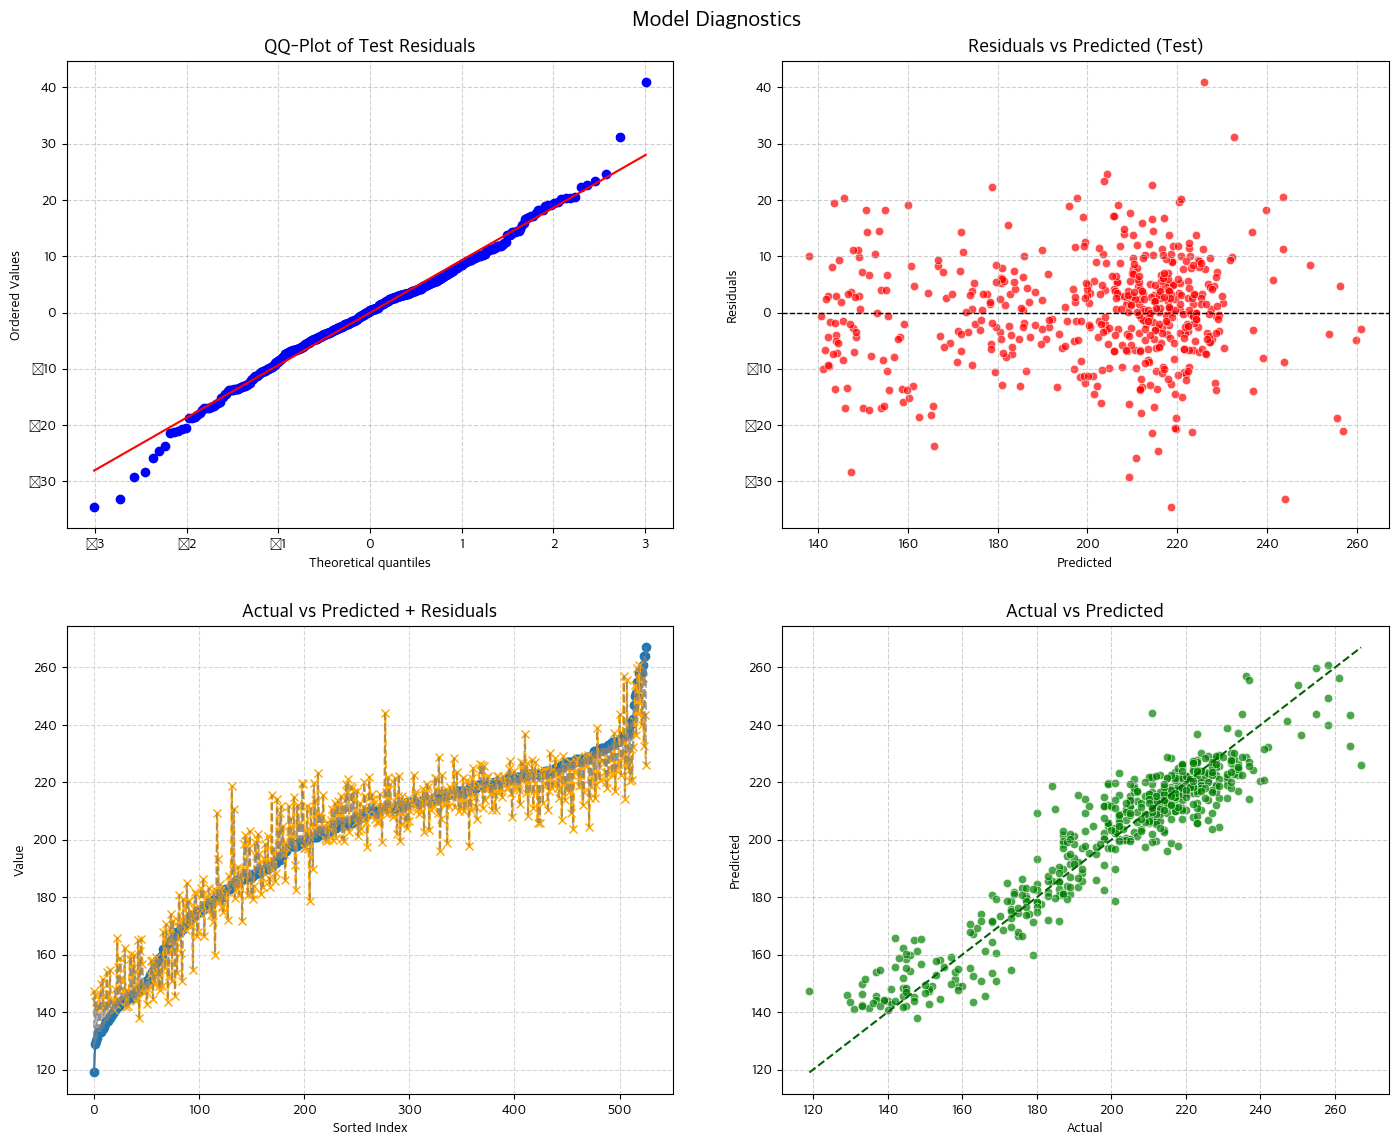

[I 2025-10-31 10:07:47,592] A new study created in memory with name: no-name-93438684-bcd5-4946-8579-f45fe501a9f3


Train Accuracy
Train RMSE : 1.007
Train R2   : 0.999
Train SMAPE : 0.40
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 9.349
Test R2   : 0.893
Test SMAPE : 3.65
학습할 Tree Features: 17 | ['step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'Vm_feature']
학습 Tree 데이터 수: 1313


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-31 10:07:50,330] Trial 0 finished with value: 25.49083427541171 and parameters: {'n_estimators': 1978, 'max_depth': 11, 'learning_rate': 0.006912151902851661, 'subsample': 0.8634713620728427, 'gamma': 0.3634906218529857, 'reg_lambda': 0.0030671158032020175}. Best is trial 0 with value: 25.49083427541171.
[I 2025-10-31 10:07:51,584] Trial 1 finished with value: 24.458029573040722 and parameters: {'n_estimators': 1042, 'max_depth': 8, 'learning_rate': 0.005009862076056521, 'subsample': 0.9431050518932632, 'gamma': 0.24034631747069585, 'reg_lambda': 0.13075519302947475}. Best is trial 1 with value: 24.458029573040722.
[I 2025-10-31 10:07:52,376] Trial 2 finished with value: 25.053307179889565 and parameters: {'n_estimators': 1733, 'max_depth': 12, 'learning_rate': 0.04228940314119804, 'subsample': 0.882745579734359, 'gamma': 0.32447833958942335, 'reg_lambda': 0.12127182539285122}. Best is trial 1 with value: 24.458029573040722.
[I 2025-10-31 10:07:54,623] Trial 3 finished with 

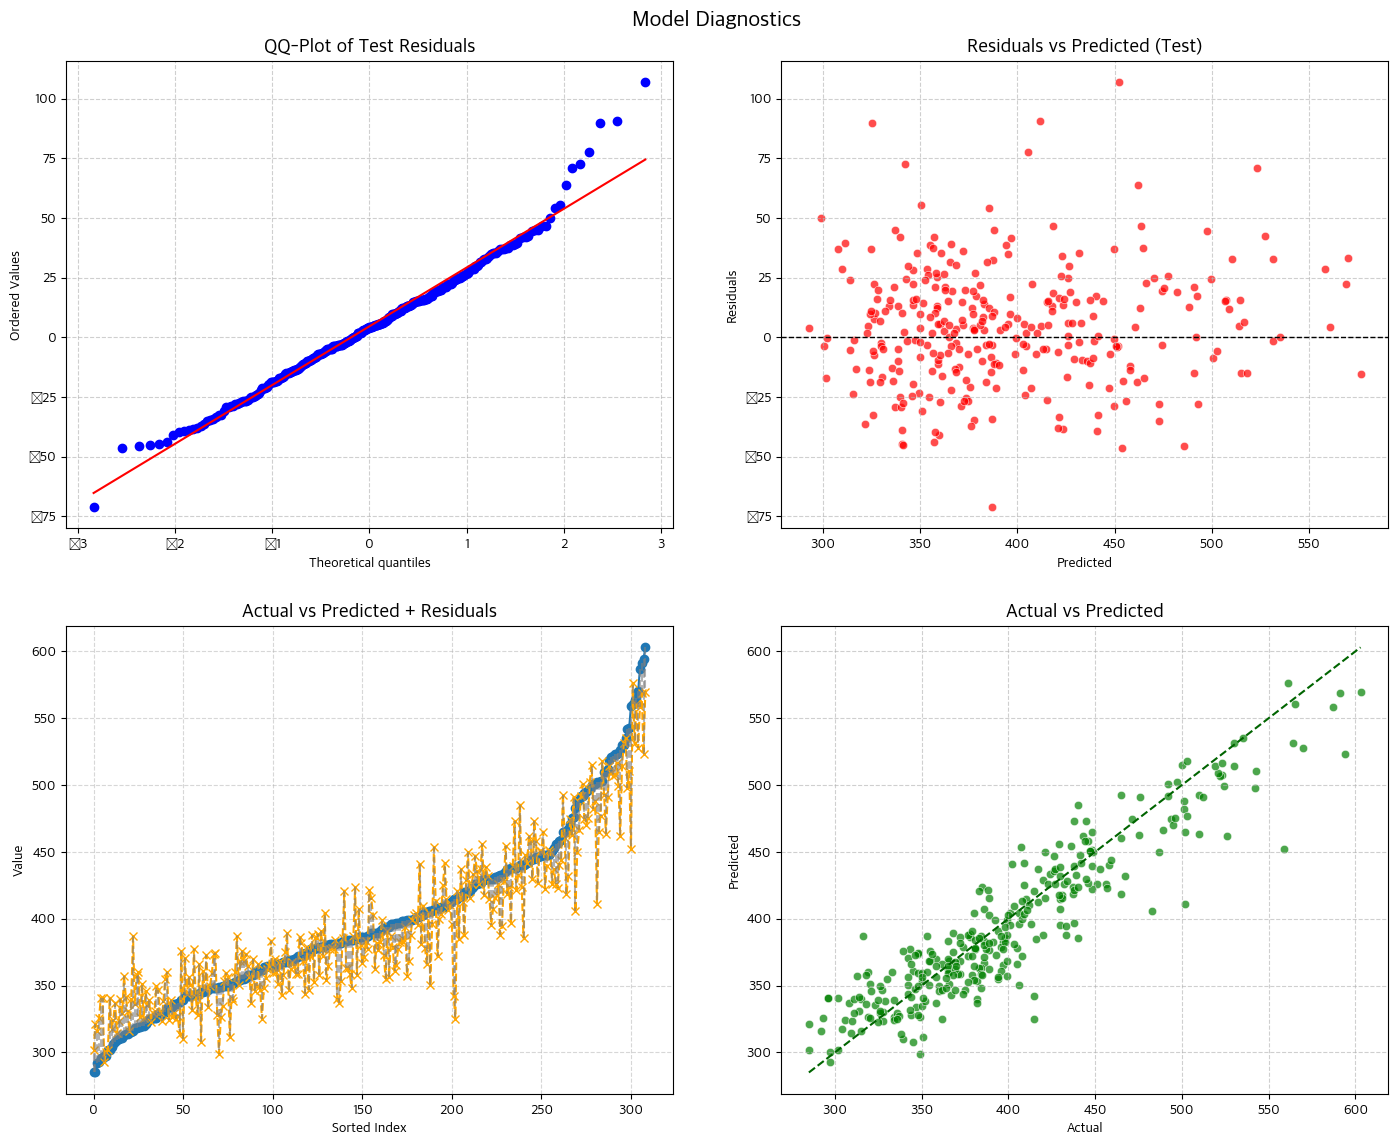

[I 2025-10-31 10:08:10,428] A new study created in memory with name: no-name-84485db5-958b-4999-9a63-36c0bcf08b80


Train Accuracy
Train RMSE : 0.166
Train R2   : 1.000
Train SMAPE : 0.03
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 25.094
Test R2   : 0.850
Test SMAPE : 4.87
학습할 Tree Features: 17 | ['step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'Vm_feature']
학습 Tree 데이터 수: 5907


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-31 10:08:10,990] Trial 0 finished with value: 6.866135330517953 and parameters: {'n_estimators': 634, 'max_depth': 12, 'learning_rate': 0.003397425692791759, 'subsample': 0.9361884090202535, 'gamma': 0.06764107284135379, 'reg_lambda': 1.4948836950492141}. Best is trial 0 with value: 6.866135330517953.
[I 2025-10-31 10:08:12,428] Trial 1 finished with value: 1.474940564141083 and parameters: {'n_estimators': 2651, 'max_depth': 8, 'learning_rate': 0.05429666093113051, 'subsample': 0.9526443034165449, 'gamma': 0.05084694372951937, 'reg_lambda': 0.11823535223774961}. Best is trial 1 with value: 1.474940564141083.
[I 2025-10-31 10:08:12,697] Trial 2 finished with value: 1.5369696859672106 and parameters: {'n_estimators': 390, 'max_depth': 6, 'learning_rate': 0.14346547479749167, 'subsample': 0.9626982251106071, 'gamma': 0.34434309314208017, 'reg_lambda': 0.007321053768105103}. Best is trial 1 with value: 1.474940564141083.
[I 2025-10-31 10:08:14,103] Trial 3 finished with value: 

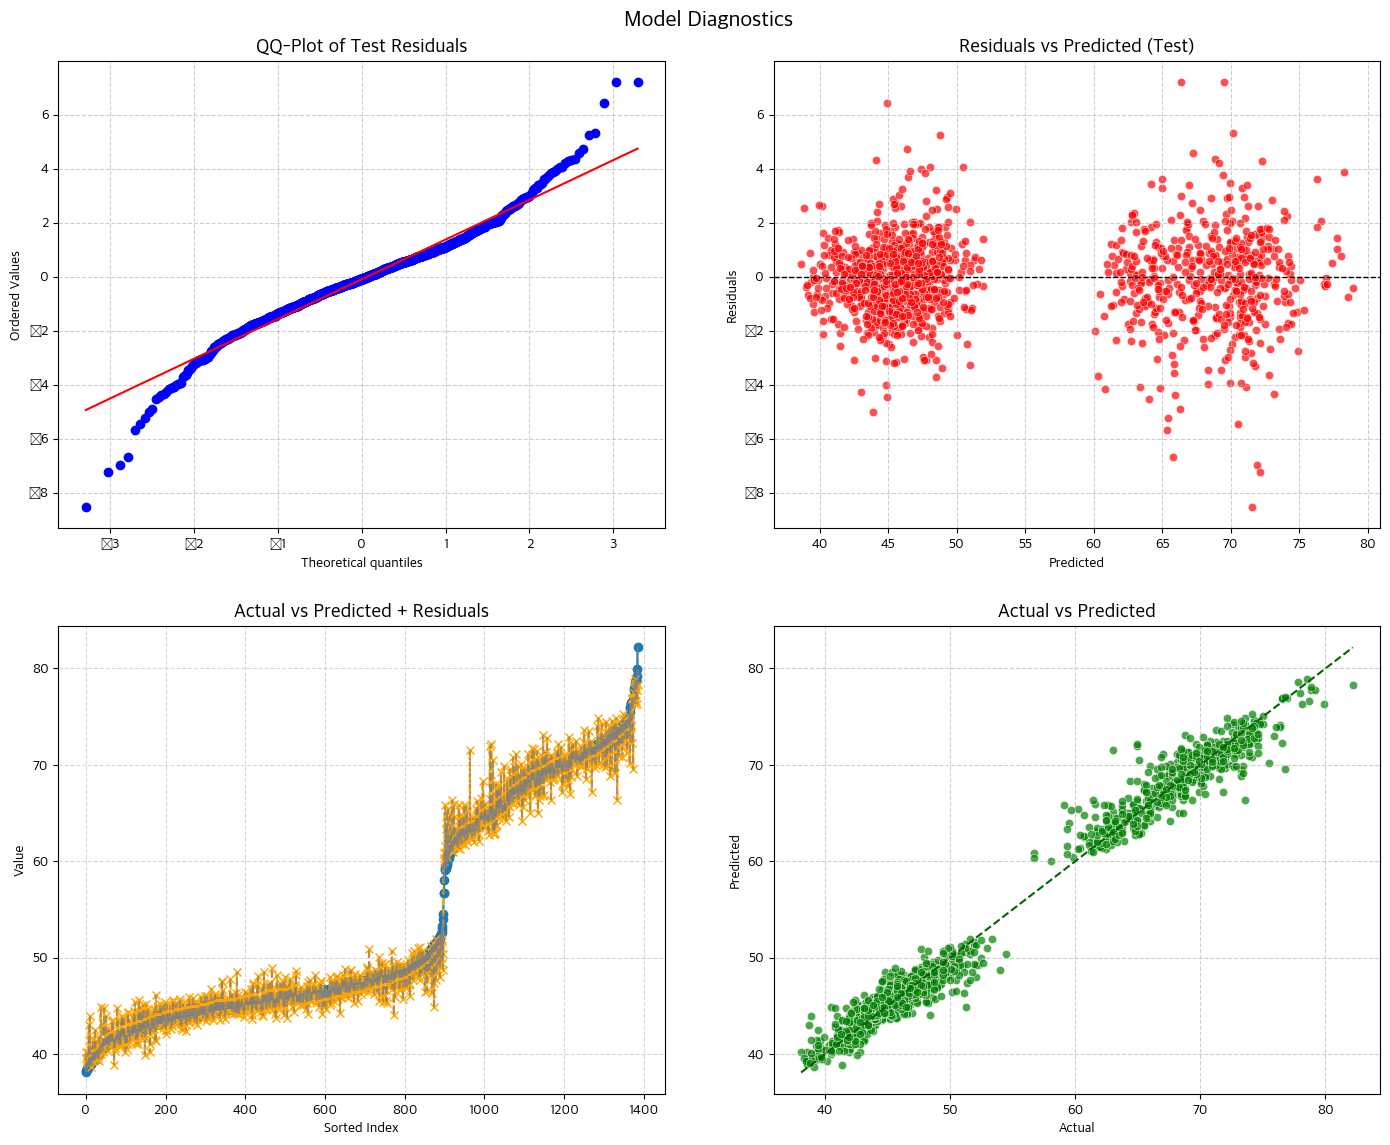

[I 2025-10-31 10:08:28,956] A new study created in memory with name: no-name-62923dbd-564b-4fad-acc8-af2044bfc12a


Train Accuracy
Train RMSE : 0.085
Train R2   : 1.000
Train SMAPE : 0.13
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 1.498
Test R2   : 0.983
Test SMAPE : 2.04
학습할 Tree Features: 17 | ['step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'Vm_feature']
학습 Tree 데이터 수: 4091


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-31 10:08:30,167] Trial 0 finished with value: 1.2217583601500719 and parameters: {'n_estimators': 2191, 'max_depth': 8, 'learning_rate': 0.023225729099461436, 'subsample': 0.9632111474628171, 'gamma': 0.30871269055237144, 'reg_lambda': 0.12237086894080479}. Best is trial 0 with value: 1.2217583601500719.
[I 2025-10-31 10:08:30,874] Trial 1 finished with value: 1.2449471725389838 and parameters: {'n_estimators': 1600, 'max_depth': 11, 'learning_rate': 0.07478779752041523, 'subsample': 0.9622938183342672, 'gamma': 0.18250925990204175, 'reg_lambda': 0.592569856176273}. Best is trial 0 with value: 1.2217583601500719.
[I 2025-10-31 10:08:32,349] Trial 2 finished with value: 1.2517583496884694 and parameters: {'n_estimators': 2411, 'max_depth': 8, 'learning_rate': 0.05778274298360448, 'subsample': 0.8684003279249399, 'gamma': 0.011516591903541484, 'reg_lambda': 0.0010649331361210312}. Best is trial 0 with value: 1.2217583601500719.
[I 2025-10-31 10:08:35,025] Trial 3 finished with

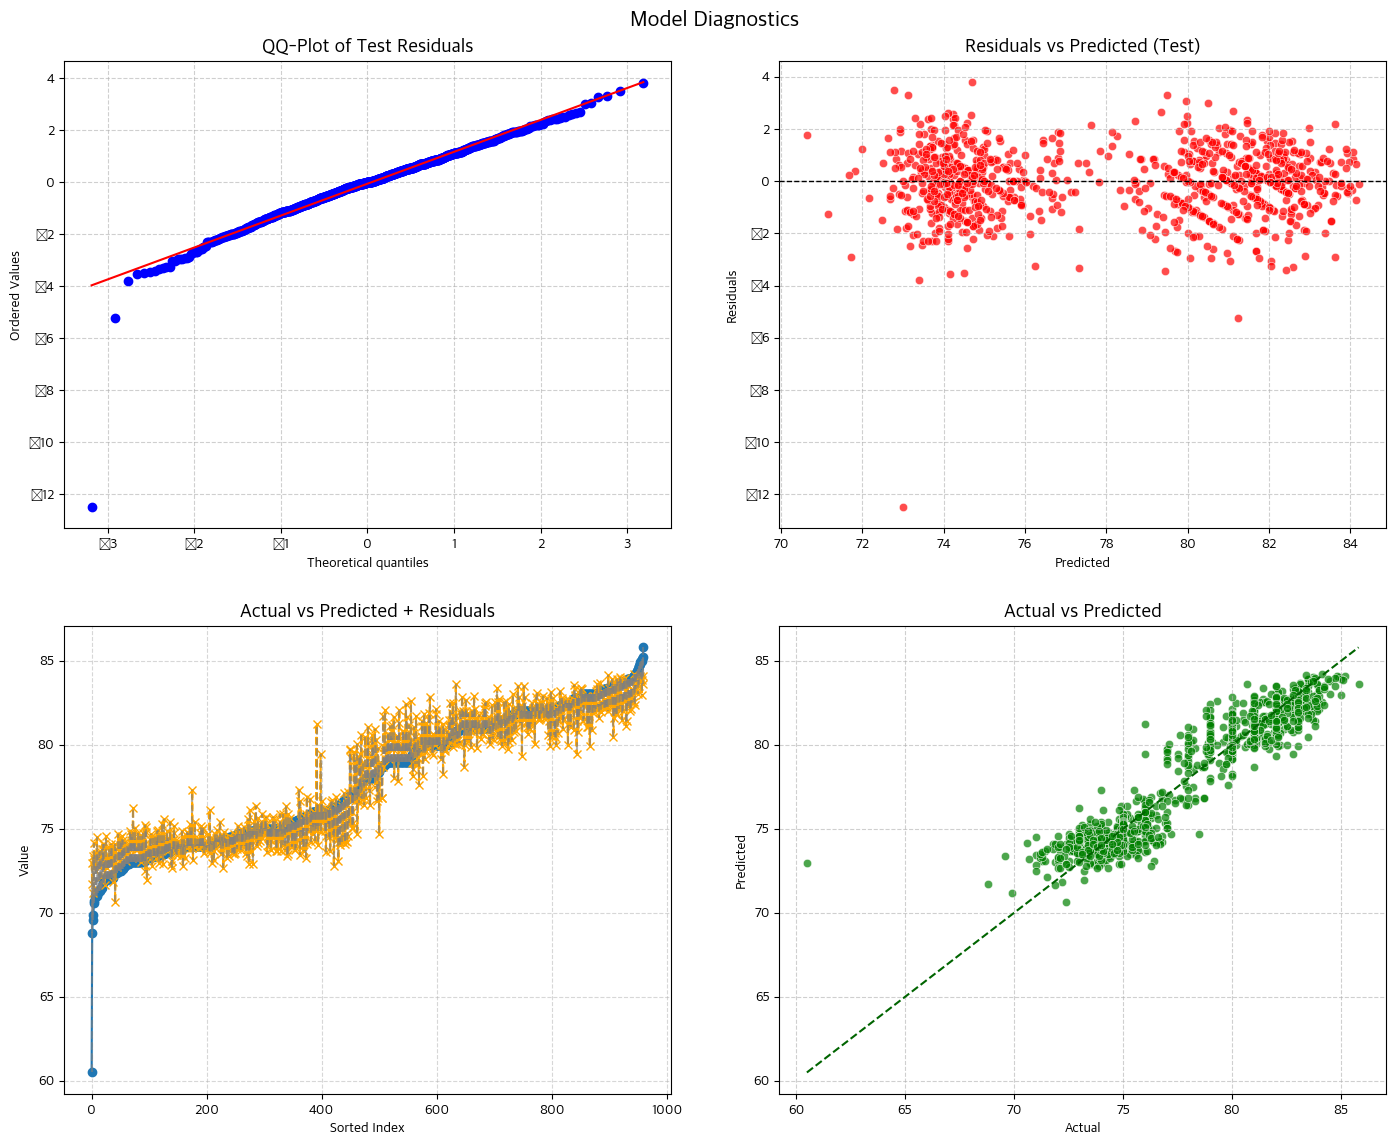

Train Accuracy
Train RMSE : 0.234
Train R2   : 0.996
Train SMAPE : 0.24
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 1.258
Test R2   : 0.894
Test SMAPE : 1.21


In [11]:
### Modelling 
# CT90 
ct_model, ct_importance = train_tree(ct_train_dataset, ct_test_dataset, target_col='Ct 90_결과')

# Scorch 
sc_model, sc_importance = train_tree(sc_train_dataset, sc_test_dataset, target_col='Scorch_결과')

# Vm 
vm_model, vm_importance = train_tree(vm_train_dataset, vm_test_dataset, target_col='Vm_결과')

# Hard 
hard_model, hard_importance = train_tree(hard_train_dataset, hard_test_dataset, target_col='경도_결과') 

## ***Feature Importance***
---

In [12]:
### Shap Tree 적용 
# CT90 
ct_shap_values, ct_filtered_dataset, ct_feature_importance = shap_tree(dataset, ct_scaler, ct_scaler_cols, ct_model, p_type, target_col=targets[0], cluster=cluster)

# Scorch 
sc_shap_values, sc_filtered_dataset, sc_feature_importance = shap_tree(dataset, sc_scaler, sc_scaler_cols, sc_model, p_type, target_col=targets[1], cluster=cluster)

# Vm 
vm_shap_values, vm_filtered_dataset, vm_feature_importance = shap_tree(dataset, vm_scaler, vm_scaler_cols, vm_model, p_type, target_col=targets[2], cluster=cluster)

# Hard 
hard_shap_values, hard_filtered_dataset, hard_feature_importance = shap_tree(dataset, hard_scaler, hard_scaler_cols, hard_model, p_type, target_col=targets[3], cluster=cluster)

# Voting 
feature_importances = [ct_feature_importance,sc_feature_importance,vm_feature_importance,hard_feature_importance]
cluster_feature_importance = voting_feature_importance(feature_importances) 

# Print 
print('='*100)
print(f'Cluster {cluster} Shap Tree Feature Importance 추출 완료')
print('='*100)

Cluster 2 | Ct 90_결과 => Feature Importance 추출 시작
Cluster 조건 적용된 데이터 수: (2767, 20)
Optimal Target 조건 적용된 데이터 수: (112, 20)
Optimal Target 조건 적용된 데이터 수: (377, 20)
Optimal Target 조건 적용된 데이터 수: (693, 20)
모든 조건이 필터링된 데이터 수: (693, 20)


 99%|===================| 683/693 [00:16<00:00]        

Cluster 2 | Scorch_결과 => Feature Importance 추출 시작
Cluster 조건 적용된 데이터 수: (1574, 20)
Optimal Target 조건 적용된 데이터 수: (101, 20)
Optimal Target 조건 적용된 데이터 수: (311, 20)
Optimal Target 조건 적용된 데이터 수: (551, 20)
모든 조건이 필터링된 데이터 수: (551, 20)


 99%|===================| 546/551 [00:55<00:00]        

Cluster 2 | Vm_결과 => Feature Importance 추출 시작
Cluster 조건 적용된 데이터 수: (7006, 20)
Optimal Target 조건 적용된 데이터 수: (215, 20)
Optimal Target 조건 적용된 데이터 수: (571, 20)
Optimal Target 조건 적용된 데이터 수: (890, 20)
모든 조건이 필터링된 데이터 수: (890, 20)


 98%|===================| 875/890 [00:29<00:00]        

Cluster 2 | 경도_결과 => Feature Importance 추출 시작
Cluster 조건 적용된 데이터 수: (5051, 20)
Optimal Target 조건 적용된 데이터 수: (440, 20)
✅ 적절한 데이터 수 확보 (1602개, std=3.00%)
모든 조건이 필터링된 데이터 수: (1602, 20)


 98%|===================| 1574/1602 [01:01<00:01]        

Cluster 2 Shap Tree Feature Importance 추출 완료


In [14]:
def voting_feature_importance(feature_importances): 
    ''' 
    각 Target별 Importance DF Voting 후 -> Top 7 Features 추출 

    Returns: Feature Importance 
    ''' 
    # Rank + Vote 컬럼 생성 
    long_frames = []

    for i, df in enumerate(feature_importances):
        # Target 이름: DataFrame.name 사용, 없으면 자동 생성
        target_name = df['Target'].iloc[0] 
        
        # Temp df 생성 
        temp_df = df[['feature', 'mean_abs_shap']].copy()

        # 내림차순 랭크 (값이 클수록 중요)
        temp_df['Rank'] = temp_df['mean_abs_shap'].rank(ascending=False, method='dense')

        # 투표 점수: importance * (1 / Rank)
        temp_df['Vote'] = temp_df['mean_abs_shap'] / temp_df['Rank']
        temp_df['Target'] = target_name

        # Append Temp df 
        long_frames.append(temp_df)
    
    # Concat Long Frames 
    long_df = pd.concat(long_frames, ignore_index=True) 

    # To Pivot 
    pivot_importance = long_df.pivot(
                                    index='Target',
                                    columns='feature',
                                    values='mean_abs_shap'
                                    )

    # Voting 집계 및 결과 DF 구성
    agg = (long_df
           .groupby('feature', as_index=False)
           .agg(
               Voting=('Vote', 'sum'),
               등장빈도=('Target', 'nunique'),
               평균중요도=('mean_abs_shap', 'mean'),
               관련타겟=('Target', lambda x: ', '.join(sorted(pd.unique(x))))
           ))

    # 사용자가 정의한 스키마로 맞추고, Voting으로 정렬하되 출력 컬럼은 틀 유지
    out = (agg
           .sort_values('Voting', ascending=False)
           .rename(columns={
               'feature': 'Features',
               '등장빈도': '등장 빈도',
               'Voting': 'Voting',
               '관련타겟': '관련 타겟'
           })[['Features', '등장 빈도', 'Voting', '관련 타겟']]
           .reset_index(drop=True))

    return out

In [15]:
cluster_feature_importance = voting_feature_importance(feature_importances) 
cluster_feature_importance

,Features,등장 빈도,Voting,관련 타겟
0,step3_Rotor speed,4,21.271163,"Ct 90_결과, Scorch_결과, Vm_결과, 경도_결과"
1,step1_Rotor speed,4,17.478467,"Ct 90_결과, Scorch_결과, Vm_결과, 경도_결과"
2,step2_mix온도,4,8.780901,"Ct 90_결과, Scorch_결과, Vm_결과, 경도_결과"
3,TA_MIN,4,3.522653,"Ct 90_결과, Scorch_결과, Vm_결과, 경도_결과"
4,필팩터,4,2.337544,"Ct 90_결과, Scorch_결과, Vm_결과, 경도_결과"
5,step3_mix온도,4,1.290400,"Ct 90_결과, Scorch_결과, Vm_결과, 경도_결과"
6,step2_time,4,1.040469,"Ct 90_결과, Scorch_결과, Vm_결과, 경도_결과"
7,TA_MAX,4,0.990994,"Ct 90_결과, Scorch_결과, Vm_결과, 경도_결과"
8,step1_mix온도,4,0.981340,"Ct 90_결과, Scorch_결과, Vm_결과, 경도_결과"
9,step1_전력량,4,0.739777,"Ct 90_결과, Scorch_결과, Vm_결과, 경도_결과"
